╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 10. CNN Architectures**
# Section 6. Batch Normalization 구현하기

### _Objective_

* Batch Normalization은 Tensorflow로 구현할 시 몇가지 주의해야 할 점들이 존재합니다.<br>
* Low-API로 어떻게 구현하는지를 살펴보고 High-API를 어떻게 이용하는지 배워보도록 하겠습니다.
  
╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf
import cv2

## Graph Visualization

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

<br>
<br>

# \[ 1. Batch Normalization 구현 \]
---
---

<br>

## 1. Batch Normalization Layer 구성하기
----



### (1) Mini-Batch 정규화 수행하기

평균과 분산을 구하는 메소드로 Tensorflow에서는 `tf.nn.moments`를 제공합니다.<br>
````python
tf.nn.moments(
    x,
    axes,
    shift=None,
    name=None,
    keep_dims=False
)
````

으로, `axes`으로 주어진 축방향에 따라, 평균과 분산을 구하게 됩니다.<br>
미니 배치 단위로 구해야 하기 때문에, 0번째 축으로 계산합니다.<br>

Variance가 0인 경우, NaN값이 나오는 것을 방지하기 위해 작은 숫자인 epsilon을 더해줍니다.<br>

In [0]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32,(None,32),name='inputs')
    epsilon = 1e-3 
    with tf.variable_scope('normalization'):
        batch_mean, batch_var = tf.nn.moments(x,[0])
        x_norm = (x-batch_mean)/tf.sqrt(batch_var+epsilon)

### (2) Scale Factor($\gamma$)와 Shift Factor($\beta$) 구성하기

Scale Factor와 Shift Factor의 초기화는 논문에 명시되어 있지 않지만<br>
원저자의 코드에 따르면, Scale Factor은 1로, Shift Factor는 0으로 초기화해줍니다.

In [0]:
with graph.as_default():
    input_size = x.get_shape()[-1]
    gamma = tf.Variable(tf.ones(input_size), name='scale_factor')
    beta = tf.Variable(tf.zeros(input_size), name='shift_factor')
    
    with tf.variable_scope('transformation'):
        y = gamma * x_norm + beta

### (3) Test 과정에서의 평균과 분산 구하기

Test 과정에서는 보통 Sample 한개씩 처리하기 때문에, 학습할 때처럼 <br>
배치 단위의 평균과 분산이 계산되지 않습니다.<br>

그렇기 때문에, 우리는 평균과 분산의 **추정치**를 계산해야 합니다.<br>
논문에서는 간략히 아래와 같이 표현되어 있습니다.

![Imgur](https://i.imgur.com/LecVZnA.png)

Moving Average는 대표적으로 Optimizer 때 배웠던,<br>
**지수이동평균(Exponential Moving Average)** 을 주로 이용합니다.

지수이동평균의 수식은 아래와 같습니다.<br>
$
s_{n+1} = (1-\beta) x_n + \beta s_n\\
x_n: \mbox{최신 정보} \\
s_n: \mbox{과거 종합 정보} \\
\beta : \mbox{계수},0<\beta<1
$

In [0]:
decay = 0.999
graph = tf.Graph()
with graph.as_default():
   #fix me#

위와 같이 Train 과정일 때에는 배치의 평균과 분산을 이용해 구하고, <br>
Test 과정일 때에는 지수이동평균으로 추정된 평균과 분산을 이용해 구하게 됩니다.<br>



### (4) `tf.nn.batch_normalization`을 이용

````python
x_norm = (x-batch_mean) / tf.sqrt(batch_var+epsilon)
y = gamma * x_norm + beta
````
대신 우리는 `tf.nn.batch_normalization`을 통해 한 줄로 작성할 수 있습니다.

In [0]:
decay = 0.999
graph = tf.Graph()
with graph.as_default():
    #fix me#

### (5) batch normalization wrapper 메소드로 정리하기

High-API가 나오기 전에, 많은 사람들이 아래와 같은 방식으로,<br>
Wrapper 메소드를 구현해 Batch Normalization 코드를 이용하였습니다.

In [0]:
def batch_normalization(inputs, is_train, decay=0.999, epsilon=1e-5):    
    #fix me#
    return y

## 2. MNIST 데이터셋을 통한 Batch Normalization의 유무 비교
----
* Mnist를 학습시키는 모델을 통해, Batch Normalization의 유무가 어떤 차이를 보이는지 확인해보도록 하겠습니다.

### (1) MNIST 불러오기

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/',one_hot=False)

W0619 07:46:46.669321 140500557862784 deprecation.py:323] From <ipython-input-10-219623c18e16>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0619 07:46:46.671215 140500557862784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0619 07:46:46.679584 140500557862784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be remove

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz


W0619 07:46:47.085227 140500557862784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0619 07:46:47.177082 140500557862784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [0]:
train_set = mnist.train
valid_set = mnist.validation
test_set = mnist.test

### (2) Batch Normalization 없는 모델 학습시키기

In [0]:
graph = tf.Graph()
with graph.as_default():
    #fix me #

In [0]:
num_epoch = 10
num_batch = 60
num_step = train_set.num_examples // num_batch

acc_history_without_bn = []

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run([tf.global_variables_initializer()])
    
    for epoch in range(num_epoch):
        #fix me #

100%|██████████| 916/916 [00:00<00:00, 949.79it/s] 


### (3) Batch Normalization을 포함한 모델 구성하기

In [0]:
def dense_bn_relu(inputs, is_train, filters, name='dense'):
    # (1) Logit 계산 -> (2) Batch Normalization 적용 -> (3) 활성화함수 
    # 순으로 연산하는 메소드
        #fix me#
        return tf.nn.relu(bn)

In [0]:
graph = tf.Graph()
with graph.as_default():
    #fix me #

In [0]:
num_epoch = 10
num_batch = 60
num_step = train_set.num_examples // num_batch

acc_history_with_bn = []

with graph.as_default():
    #fix me#

100%|██████████| 916/916 [00:01<00:00, 512.16it/s]


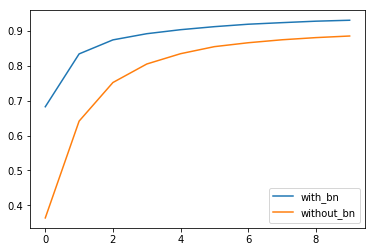

In [0]:
plt.plot(acc_history_with_bn, label='with_bn')
plt.plot(acc_history_without_bn, label='without_bn')
plt.legend()
plt.show()

배치노말 레이어가 있었을 때, 훨씬 더 빠르게 수렴함을 알 수 있습니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/07

---